In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import re
from typing import Optional
from nerfstudio.cameras.rays import RaySamples, Frustums
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils import colormaps, misc

from reni.configs.reni_config import RENIField
from reni.configs.sh_sg_envmap_configs import SHField, SGField
from reni.pipelines.reni_pipeline import RENIPipeline
from reni.field_components.field_heads import RENIFieldHeadNames
from reni.data.datamanagers.reni_datamanager import RENIDataManager
from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.utils.colourspace import linear_to_sRGB

In [2]:
# setup config
world_size = 1
local_rank = 0
device = 'cuda:0'

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

def load_model(load_dir: Path, load_step: Optional[int] = None):
    ckpt_dir = load_dir / 'nerfstudio_models'
    def clean_and_load_yaml(yaml_content):
        # Remove !!python related tags
        cleaned_content = re.sub(r'!!python[^\s]*', '', yaml_content)
        
        # Load the cleaned content
        return yaml.safe_load(cleaned_content)

    if load_step is None:
        load_step = sorted(int(x[x.find("-") + 1 : x.find(".")]) for x in os.listdir(ckpt_dir))[-1]
    
    ckpt = torch.load(ckpt_dir / f'step-{load_step:09d}.ckpt', map_location=device)
    reni_model_dict = {}
    for key in ckpt['pipeline'].keys():
        if key.startswith('_model.'):
            reni_model_dict[key[7:]] = ckpt['pipeline'][key]
    
    config_path = load_dir / 'config.yml'
    with open(config_path, 'r') as f:
        content = f.read()
        config = clean_and_load_yaml(content)
    
    if 'latent_dim' in config['pipeline']['model']['field'].keys():
        
        model_config = RENIField.config
        model_config.pipeline.datamanager.dataparser.convert_to_ldr = config['pipeline']['datamanager']['dataparser']['convert_to_ldr']
        model_config.pipeline.datamanager.dataparser.convert_to_log_domain = config['pipeline']['datamanager']['dataparser']['convert_to_log_domain']
        if config['pipeline']['datamanager']['dataparser']['eval_mask_path'] is not None:
            eval_mask_path = Path(os.path.join(*config['pipeline']['datamanager']['dataparser']['eval_mask_path']))
            model_config.pipeline.datamanager.dataparser.eval_mask_path = eval_mask_path
        else:
            model_config.pipeline.datamanager.dataparser.eval_mask_path = None
        if config['pipeline']['datamanager']['dataparser']['min_max_normalize'].__class__ == list:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = tuple(config['pipeline']['datamanager']['dataparser']['min_max_normalize'])
        else:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = config['pipeline']['datamanager']['dataparser']['min_max_normalize']
        model_config.pipeline.datamanager.dataparser.augment_with_mirror = config['pipeline']['datamanager']['dataparser']['augment_with_mirror']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
        model_config.pipeline.model.field.conditioning = config['pipeline']['model']['field']['conditioning']
        model_config.pipeline.model.field.invariant_function = config['pipeline']['model']['field']['invariant_function']
        model_config.pipeline.model.field.equivariance = config['pipeline']['model']['field']['equivariance']
        model_config.pipeline.model.field.axis_of_invariance = config['pipeline']['model']['field']['axis_of_invariance']
        model_config.pipeline.model.field.positional_encoding = config['pipeline']['model']['field']['positional_encoding']
        model_config.pipeline.model.field.encoded_input = config['pipeline']['model']['field']['encoded_input']
        model_config.pipeline.model.field.latent_dim = config['pipeline']['model']['field']['latent_dim']
        model_config.pipeline.model.field.hidden_features = config['pipeline']['model']['field']['hidden_features']
        model_config.pipeline.model.field.hidden_layers = config['pipeline']['model']['field']['hidden_layers']
        model_config.pipeline.model.field.mapping_layers = config['pipeline']['model']['field']['mapping_layers']
        model_config.pipeline.model.field.mapping_features = config['pipeline']['model']['field']['mapping_features']
        model_config.pipeline.model.field.num_attention_heads = config['pipeline']['model']['field']['num_attention_heads']
        model_config.pipeline.model.field.num_attention_layers = config['pipeline']['model']['field']['num_attention_layers']
        model_config.pipeline.model.field.output_activation = config['pipeline']['model']['field']['output_activation']
        model_config.pipeline.model.field.last_layer_linear = config['pipeline']['model']['field']['last_layer_linear']
        model_config.pipeline.model.field.trainable_scale = config['pipeline']['model']['field']['trainable_scale']
        model_config.pipeline.model.field.old_implementation = config['pipeline']['model']['field']['old_implementation']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
    elif 'spherical_harmonic_order' in config['pipeline']['model']['field'].keys():
        model_config = SHField.config
        model_config.pipeline.model.field.spherical_harmonic_order = config['pipeline']['model']['field']['spherical_harmonic_order']
    elif 'row_col_gaussian_dims' in config['pipeline']['model']['field'].keys():
        model_config = SGField.config
        model_config.pipeline.model.field.row_col_gaussian_dims = config['pipeline']['model']['field']['row_col_gaussian_dims']

    model_config.pipeline.test_mode = config['pipeline']['test_mode']
    test_mode = model_config.pipeline.test_mode
    
    pipeline: RENIPipeline = model_config.pipeline.setup(
      device=device,
      test_mode=test_mode,
      world_size=world_size,
      local_rank=local_rank,
      grad_scaler=None,
    )

    datamanager = pipeline.datamanager

    model = pipeline.model

    model.to(device)
    model.load_state_dict(reni_model_dict)
    model.eval()

    return pipeline, datamanager, model

def generate_images_from_models(image_indices, model_paths):
    all_model_outputs = {}
    
    for model_path in model_paths:
        model_name = model_path.split("/")[-1]
        pipeline, datamanager, model = load_model(Path(model_path))
        
        model_outputs = {}
        
        for idx in image_indices:
            # Your code to produce an image would go here.
            model.eval()
            _, ray_bundle, batch = datamanager.next_eval_image(idx)
            H, W = model.metadata["image_height"], model.metadata["image_width"]

            # High res image:
            H = 64
            W = H * 2
            cx = torch.tensor(W // 2, dtype=torch.float32).repeat(1)
            cy = torch.tensor(H // 2, dtype=torch.float32).repeat(1)
            fx = torch.tensor(H, dtype=torch.float32).repeat(1)
            fy = torch.tensor(H, dtype=torch.float32).repeat(1)

            c2w = torch.tensor([[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)

            cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

            ray_bundle = cameras.generate_rays(0).flatten().to(device)
            ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * idx

            batch['image'] = batch['image'].to(device)

            # check if the model has attribute old_implementation
            if hasattr(model.field, 'old_implementation'):
                if model.field.old_implementation:
                    get_rotation = rot_y
                else:
                    get_rotation = rot_z

            rotation = get_rotation(torch.tensor(np.deg2rad(0.0)).float())
            rotation = rotation.to(device)

            outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle)

            pred_img = model.field.unnormalise(outputs['rgb'])
            gt_image = model.field.unnormalise(batch['image'])

            # rehsape to H, W, C
            gt_image = gt_image.reshape(H, W, 3)
            pred_img = pred_img.reshape(H, W, 3)

            # converting to grayscale by taking the mean across the color dimension
            gt_image_gray = torch.mean(gt_image, dim=-1)
            pred_image_gray = torch.mean(pred_img, dim=-1)

            # reshape to H, W
            gt_image_gray = gt_image_gray.reshape(H, W, 1)
            pred_image_gray = pred_image_gray.reshape(H, W, 1)

            gt_min, gt_max = torch.min(gt_image_gray), torch.max(gt_image_gray)

            combined_log_heatmap = torch.cat([gt_image_gray, pred_image_gray], dim=1)

            combined_log_heatmap = colormaps.apply_depth_colormap(
                combined_log_heatmap,
                near_plane=gt_min,
                far_plane=gt_max,
            )

            gt_heatmap = combined_log_heatmap[:, :W, :]
            pred_heatmap = combined_log_heatmap[:, W:, :]

            pred_img = linear_to_sRGB(pred_img, use_quantile=True)
            gt_img = linear_to_sRGB(gt_image, use_quantile=True)

            if 'mask' in batch:
                mask = batch["mask"].reshape(H, W, 1).expand_as(
                    gt_img
                ).to(device) # [H, W, 3]
                # we should mask gt_image_ldr to show only the pixels that were used in the loss
                gt_img = gt_img * mask

            model_outputs[idx] = {'pred_img': pred_img.cpu().detach(),
                                  'gt_img': gt_img.cpu().detach(),
                                  'pred_heatmap': pred_heatmap.cpu().detach(),
                                  'gt_heatmap': gt_heatmap.cpu().detach(),
                                  'min_max': (gt_min, gt_max)}
        
        if 'masked' in model_path:
            model_name = model_name + '_masked'
            
        all_model_outputs[model_name] = model_outputs
    
    return all_model_outputs

def generate_numerical_results_from_models(model_paths):
    all_model_outputs = {}
    
    for model_path in model_paths:
        model_name = model_path.split("/")[-1]
        pipeline, datamanager, model = load_model(Path(model_path))

        if hasattr(model.field, 'latent_dim'):
            metrics_dict = pipeline.get_average_eval_image_metrics(optimise_latents=False)
        else:
            metrics_dict = pipeline.get_average_eval_image_metrics()
        
        if 'old' in model_path:
            model_name = model_name + '_old'
        all_model_outputs[model_name] = metrics_dict
    
    return all_model_outputs


In [3]:
%%capture
image_indices = [1, 2, 3, 4]
model_paths = [
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_9',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_49',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100',
    '/workspace/outputs/reni/spherical_harmonics/2nd_order',
    '/workspace/outputs/reni/spherical_harmonics/6th_order',
    '/workspace/outputs/reni/spherical_harmonics/9th_order',
    '/workspace/outputs/reni/spherical_gaussians/num_param_30',
    '/workspace/outputs/reni/spherical_gaussians/num_param_150',
    '/workspace/outputs/reni/spherical_gaussians/num_param_300'
]

output_images = generate_images_from_models(image_indices, model_paths)


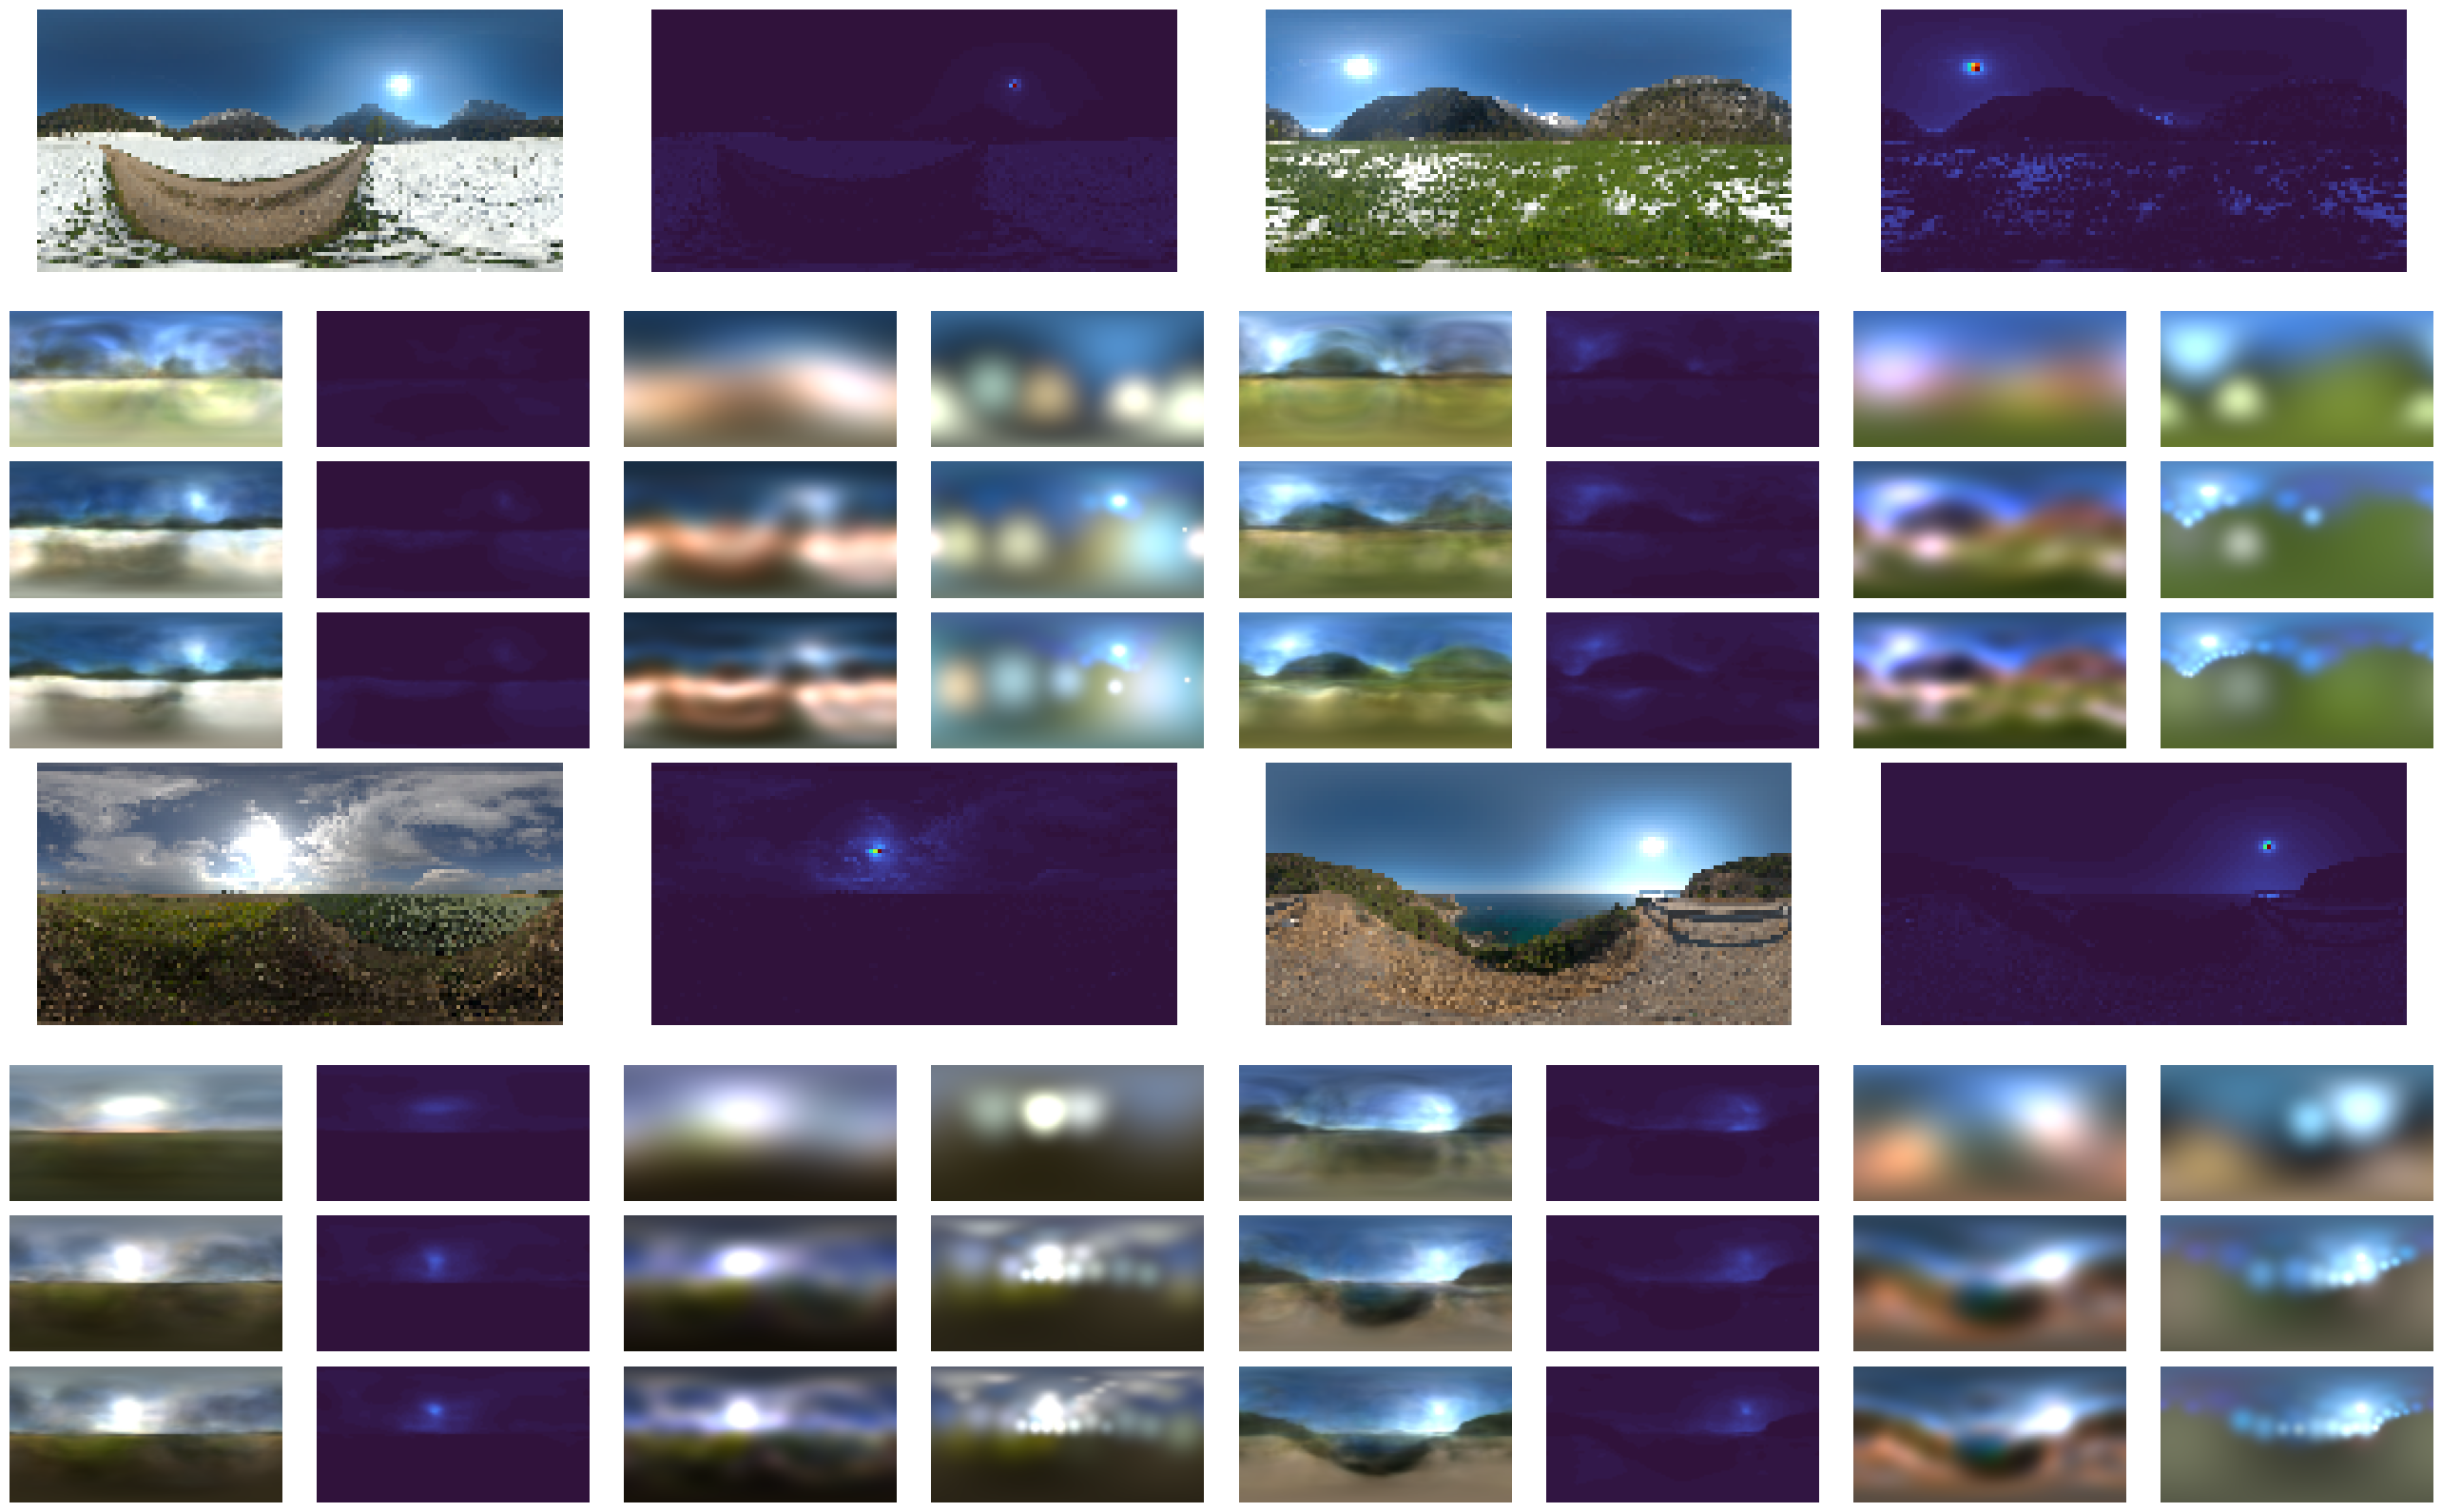

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

def plot_images_quadrants(output_images, image_indices, filename=None):
    fig = plt.figure(figsize=(26,16)) # Adjusted for equirectangular

    reni_tags = ['latent_dim_9', 'latent_dim_49', 'latent_dim_100']
    sh_tags = ['2nd_order', '6th_order', '9th_order']
    sg_tags = ['num_param_30', 'num_param_150', 'num_param_300']
    
    rows_per_idx = len(reni_tags) + 2
    cols_per_model = 4  # 2 for reni, 1 for sh and 1 for sg
    
    for i, idx in enumerate(image_indices):
        row_offset = (i // 2) * rows_per_idx
        col_offset = (i % 2) * cols_per_model

        # GT image and heatmap
        gt_img = output_images[reni_tags[0]][idx]['gt_img']
        gt_heatmap = output_images[reni_tags[0]][idx]['gt_heatmap']

        # Calculate the padding
        h, w, _ = gt_img.shape
        padding_percent = 10
        padding = int(h * padding_percent / 100.0)
        
        # Pad the images
        padded_gt_img = np.pad(gt_img, [(0, padding), (0, 0), (0, 0)], mode='constant', constant_values=1)
        padded_gt_heatmap = np.pad(gt_heatmap, [(0, padding), (0, 0), (0, 0)], mode='constant', constant_values=1)
        
        # GT image and heatmap
        ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset, col_offset), rowspan=2, colspan=2)
        ax.imshow(padded_gt_img)
        ax.axis('off')
        ax.set_aspect(1)

        ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset, col_offset+2), rowspan=2, colspan=2)
        ax.imshow(padded_gt_heatmap)
        ax.axis('off')
        ax.set_aspect(1)

        for j in range(3):  # 3 model sizes
            # RENI images
            ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset + 2 + j, col_offset))
            ax.imshow(output_images[reni_tags[j]][idx]['pred_img'])
            ax.axis('off')
            ax.set_aspect(1)

            ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset + 2 + j, col_offset + 1))
            ax.imshow(output_images[reni_tags[j]][idx]['pred_heatmap'])
            ax.axis('off')
            ax.set_aspect(1)

            # Spherical Harmonics images
            ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset + 2 + j, col_offset + 2))
            ax.imshow(output_images[sh_tags[j]][idx]['pred_img'])
            ax.axis('off')
            ax.set_aspect(1)
            
            # Spherical Gaussians
            ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset + 2 + j, col_offset + 3))
            ax.imshow(output_images[sg_tags[j]][idx]['pred_img'])
            ax.axis('off')
            ax.set_aspect(1)
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(f"{filename}.png")
        plt.savefig(f"{filename}.pdf")
    
    plt.show()

# Assuming output_images is defined
plot_images_quadrants(output_images, image_indices, filename='reni_neus/ns_reni/publication/figures/comparison')

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

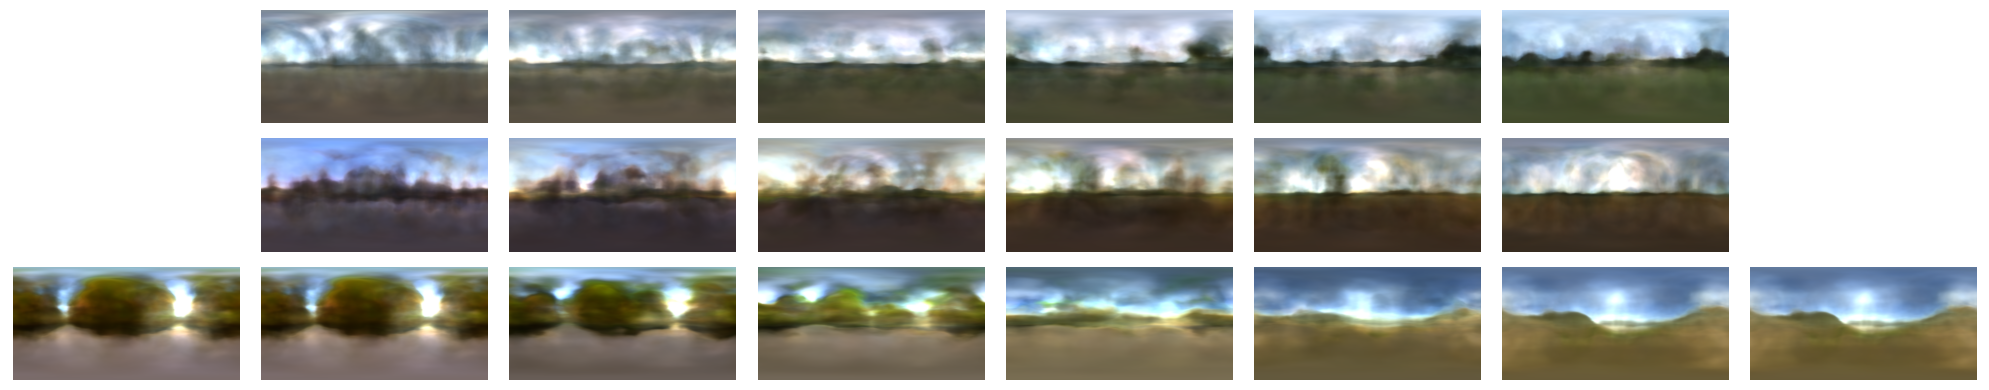

In [18]:
# Interpolation
def lerp(start, end, t):
    return start * (1 - t) + end * t

import matplotlib.pyplot as plt
import numpy as np
import torch

pipeline, datamanager, model = load_model(Path('/workspace/neusky/ns_reni/models/reni_plus_plus_models/latent_dim_100'))
model.eval()
idx = 0
_, ray_bundle, batch = datamanager.next_eval_image(idx)
H, W = model.metadata["image_height"], model.metadata["image_width"]

# High res image:
H = 256
W = H * 2
cx = torch.tensor(W // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(H // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(H, dtype=torch.float32).repeat(1)
fy = torch.tensor(H, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(0).flatten().to(device)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * idx

batch['image'] = batch['image'].to(device)

# we need ray_samples for the field
if len(ray_bundle.directions.shape) == 3: # [2, num_rays, 3]
    assert model.config.loss_inclusions['scale_inv_grad_loss']
    assert ray_bundle.directions.shape[0] == 2
    # then we are using the finite diff gradient matching loss
    # and the ray_bundle is of shape [2, num_rays, 3]
    # we the second half of the rays are just the directions rolled by 1
    ray_samples = model.create_ray_samples(ray_bundle.origins[0], ray_bundle.directions[0], ray_bundle.camera_indices[0])
else:
    ray_samples = model.create_ray_samples(ray_bundle.origins, ray_bundle.directions, ray_bundle.camera_indices)

if model.field.old_implementation:
    get_rotation = rot_y
else:
    get_rotation = rot_z

def plot_interpolated_images(model, K=10, idx1=None, idx2=None, rand1=None, rand2=None, filename=None):
    # Create a figure with 3 rows, but now K+2 columns for the last row
    fig, axs = plt.subplots(3, K + 2, figsize=(20, 4))
    
    # Hide the extra two columns in the first two rows
    for row in range(2):
        axs[row, -1].axis('off')
        axs[row, 0].axis('off')
        
        if rand1 is None:
            latent_code_1 = torch.randn(1, model.field.latent_dim, 3).to(device)
        else:
            latent_code_1 = rand1[row] # [latent_dim, 3]
        
        if rand2 is None:
            latent_code_2 = torch.randn(1, model.field.latent_dim, 3).to(device)
        else:
            latent_code_2 = rand2[row]
        
        for col in range(1, K + 1):
            t = (col - 1) / (K - 1)
            interpolated_latent_code = lerp(latent_code_1, latent_code_2, t)
            interpolated_latent_code = interpolated_latent_code.repeat(ray_samples.shape[0], 1, 1)
            
            field_outputs = model.field.forward(ray_samples, rotation=None, latent_codes=interpolated_latent_code)
            image = field_outputs[RENIFieldHeadNames.RGB].reshape(H, W, 3)
            image = model.field.unnormalise(image)
            image = linear_to_sRGB(image, use_quantile=True)
            image = image.cpu().detach()
            
            axs[row, col].imshow(image.numpy())
            axs[row, col].axis('off')
    
    if idx1 is None:
        idx1 = np.random.choice(range(len(datamanager.eval_dataset)))
    if idx2 is None:
        idx2 = np.random.choice(range(len(datamanager.eval_dataset)))

    latent_code_1 = model.field.eval_mu[idx1].unsqueeze(0)
    latent_code_2 = model.field.eval_mu[idx2].unsqueeze(0)
    
    # Show uninterpolated latent codes on either end
    for col, latent_code in zip([0, -1], [latent_code_1, latent_code_2]):
        pure_latent_code = latent_code.repeat(ray_samples.shape[0], 1, 1)
        field_outputs = model.field.forward(ray_samples, rotation=None, latent_codes=pure_latent_code)
        image = field_outputs[RENIFieldHeadNames.RGB].reshape(H, W, 3)
        image = model.field.unnormalise(image)
        image = linear_to_sRGB(image, use_quantile=True)
        image = image.cpu().detach()
        
        axs[2, col].imshow(image.numpy())
        axs[2, col].axis('off')
    
    # Show interpolated latent codes
    for col in range(1, K + 1):
        t = (col - 1) / (K - 1)
        interpolated_latent_code = lerp(latent_code_1, latent_code_2, t)
        interpolated_latent_code = interpolated_latent_code.repeat(ray_samples.shape[0], 1, 1)
        
        field_outputs = model.field.forward(ray_samples, rotation=None, latent_codes=interpolated_latent_code)
        image = field_outputs[RENIFieldHeadNames.RGB].reshape(H, W, 3)
        image = model.field.unnormalise(image)
        image = linear_to_sRGB(image, use_quantile=True)
        image = image.cpu().detach()
        
        axs[2, col].imshow(image.numpy())
        axs[2, col].axis('off')
    
    plt.tight_layout()

    if filename:
        plt.savefig(f"{filename}.png")
        plt.savefig(f"{filename}.pdf")
    
    plt.show()

torch.manual_seed(54) # 45
torch.cuda.manual_seed_all(54)

plot_interpolated_images(model, 6, idx1=6, idx2=12, filename='neusky/ns_reni/publication/figures/interpolations_and_random_samples')

In [7]:

latent_code = torch.randn(1, model.field.latent_dim, 3).to(device)
latent_code = latent_code.repeat(ray_samples.shape[0], 1, 1)
field_outputs = model.field.forward(ray_samples, rotation=None, latent_codes=latent_code)
image = field_outputs[RENIFieldHeadNames.RGB].reshape(H, W, 3)
image = model.field.unnormalise(image)
image = linear_to_sRGB(image, use_quantile=True)
image = image.cpu().detach()
plt.imshow(image.numpy())

OutOfMemoryError: CUDA out of memory. Tried to allocate 200.00 MiB (GPU 0; 15.72 GiB total capacity; 13.41 GiB already allocated; 100.88 MiB free; 13.93 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [3]:
%%capture
# Masking
image_indices = [1, 2, 3, 4, 5, 6]
model_paths = [
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100',
    '/workspace/outputs/reni/reni_plus_plus_models/masked_models/latent_dim_100'
]

output_images = generate_images_from_models(image_indices, model_paths)

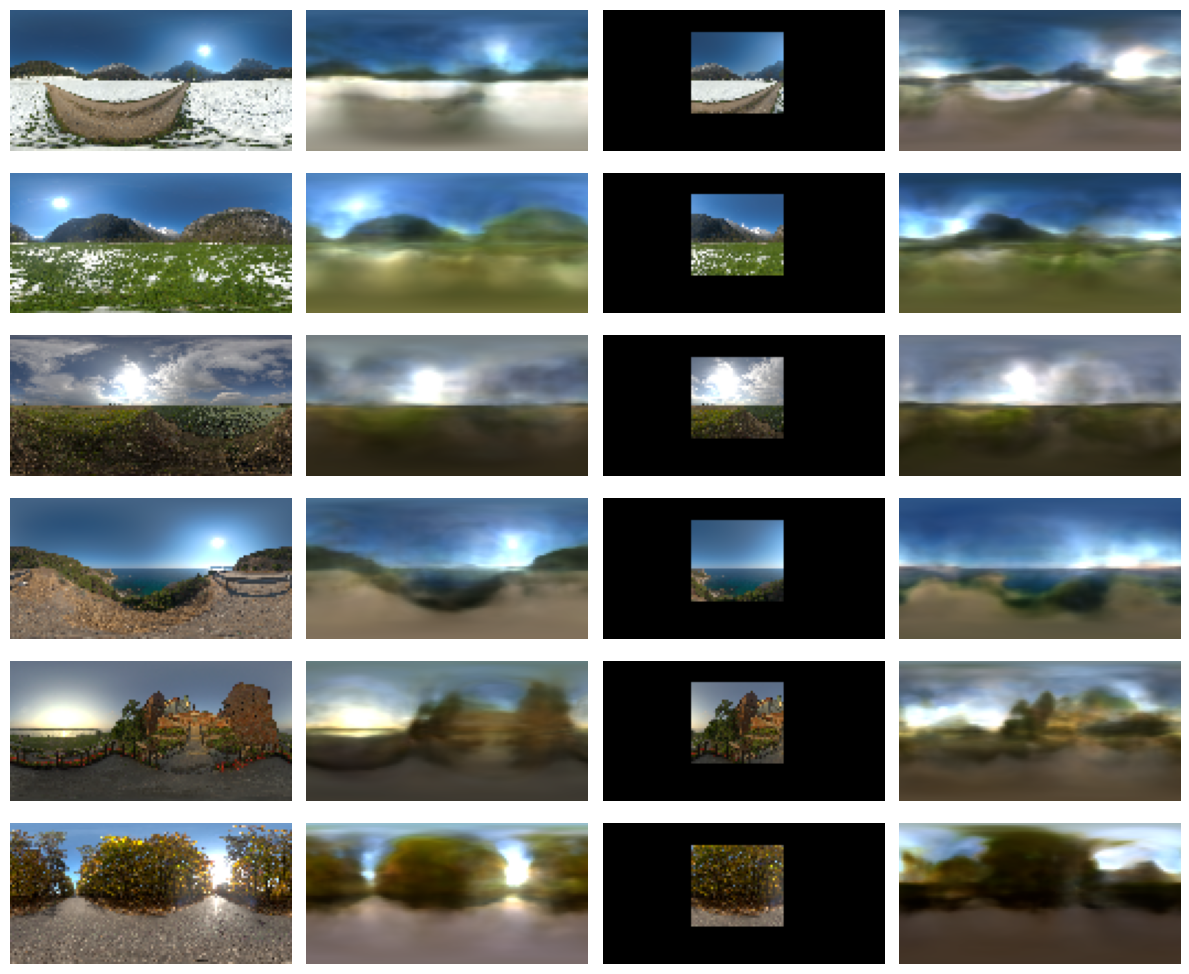

In [17]:
def outpainting_figure(output_images, keys, image_indices, filename=None):
    n_rows = len(image_indices)
    n_cols = 4  # Two pairs of ground truth and predicted images
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    
    for i, idx in enumerate(image_indices):
        # Plot ground truth and predicted images for 'latent_dim_100'
        gt_img1 = output_images[keys[0]][idx]['gt_img']
        pred_img1 = output_images[keys[0]][idx]['pred_img']
        axes[i, 0].imshow(gt_img1)
        axes[i, 0].axis('off')
        axes[i, 0].set_aspect(1)
        
        axes[i, 1].imshow(pred_img1)
        axes[i, 1].axis('off')
        axes[i, 1].set_aspect(1)
        
        # Plot ground truth and predicted images for 'latent_dim_100_masked'
        gt_img2 = output_images[keys[1]][idx]['gt_img']
        pred_img2 = output_images[keys[1]][idx]['pred_img']
        axes[i, 2].imshow(gt_img2)
        axes[i, 2].axis('off')
        axes[i, 2].set_aspect(1)
        
        axes[i, 3].imshow(pred_img2)
        axes[i, 3].axis('off')
        axes[i, 3].set_aspect(1)
    
    plt.tight_layout()

    if filename:
        plt.savefig(f"{filename}.png")
        plt.savefig(f"{filename}.pdf")
    

    plt.show()


keys = ['latent_dim_100', 'latent_dim_100_masked']
image_indices = [1, 2, 3, 4, 5, 6]

outpainting_figure(output_images, keys, image_indices, filename='reni_neus/ns_reni/publication/figures/outpainting')

In [3]:
%%capture
# Masking
image_indices = [6, 7, 8, 9, 10]
old_model_paths = [
    '/workspace/outputs/reni/old_reni_models/latent_dim_9',
    '/workspace/outputs/reni/old_reni_models/latent_dim_49',
    '/workspace/outputs/reni/old_reni_models/latent_dim_100',
]

new_model_paths = [
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_9',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_49',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100'
]


old_output_images = generate_images_from_models(image_indices, old_model_paths)
new_output_images = generate_images_from_models(image_indices, new_model_paths)

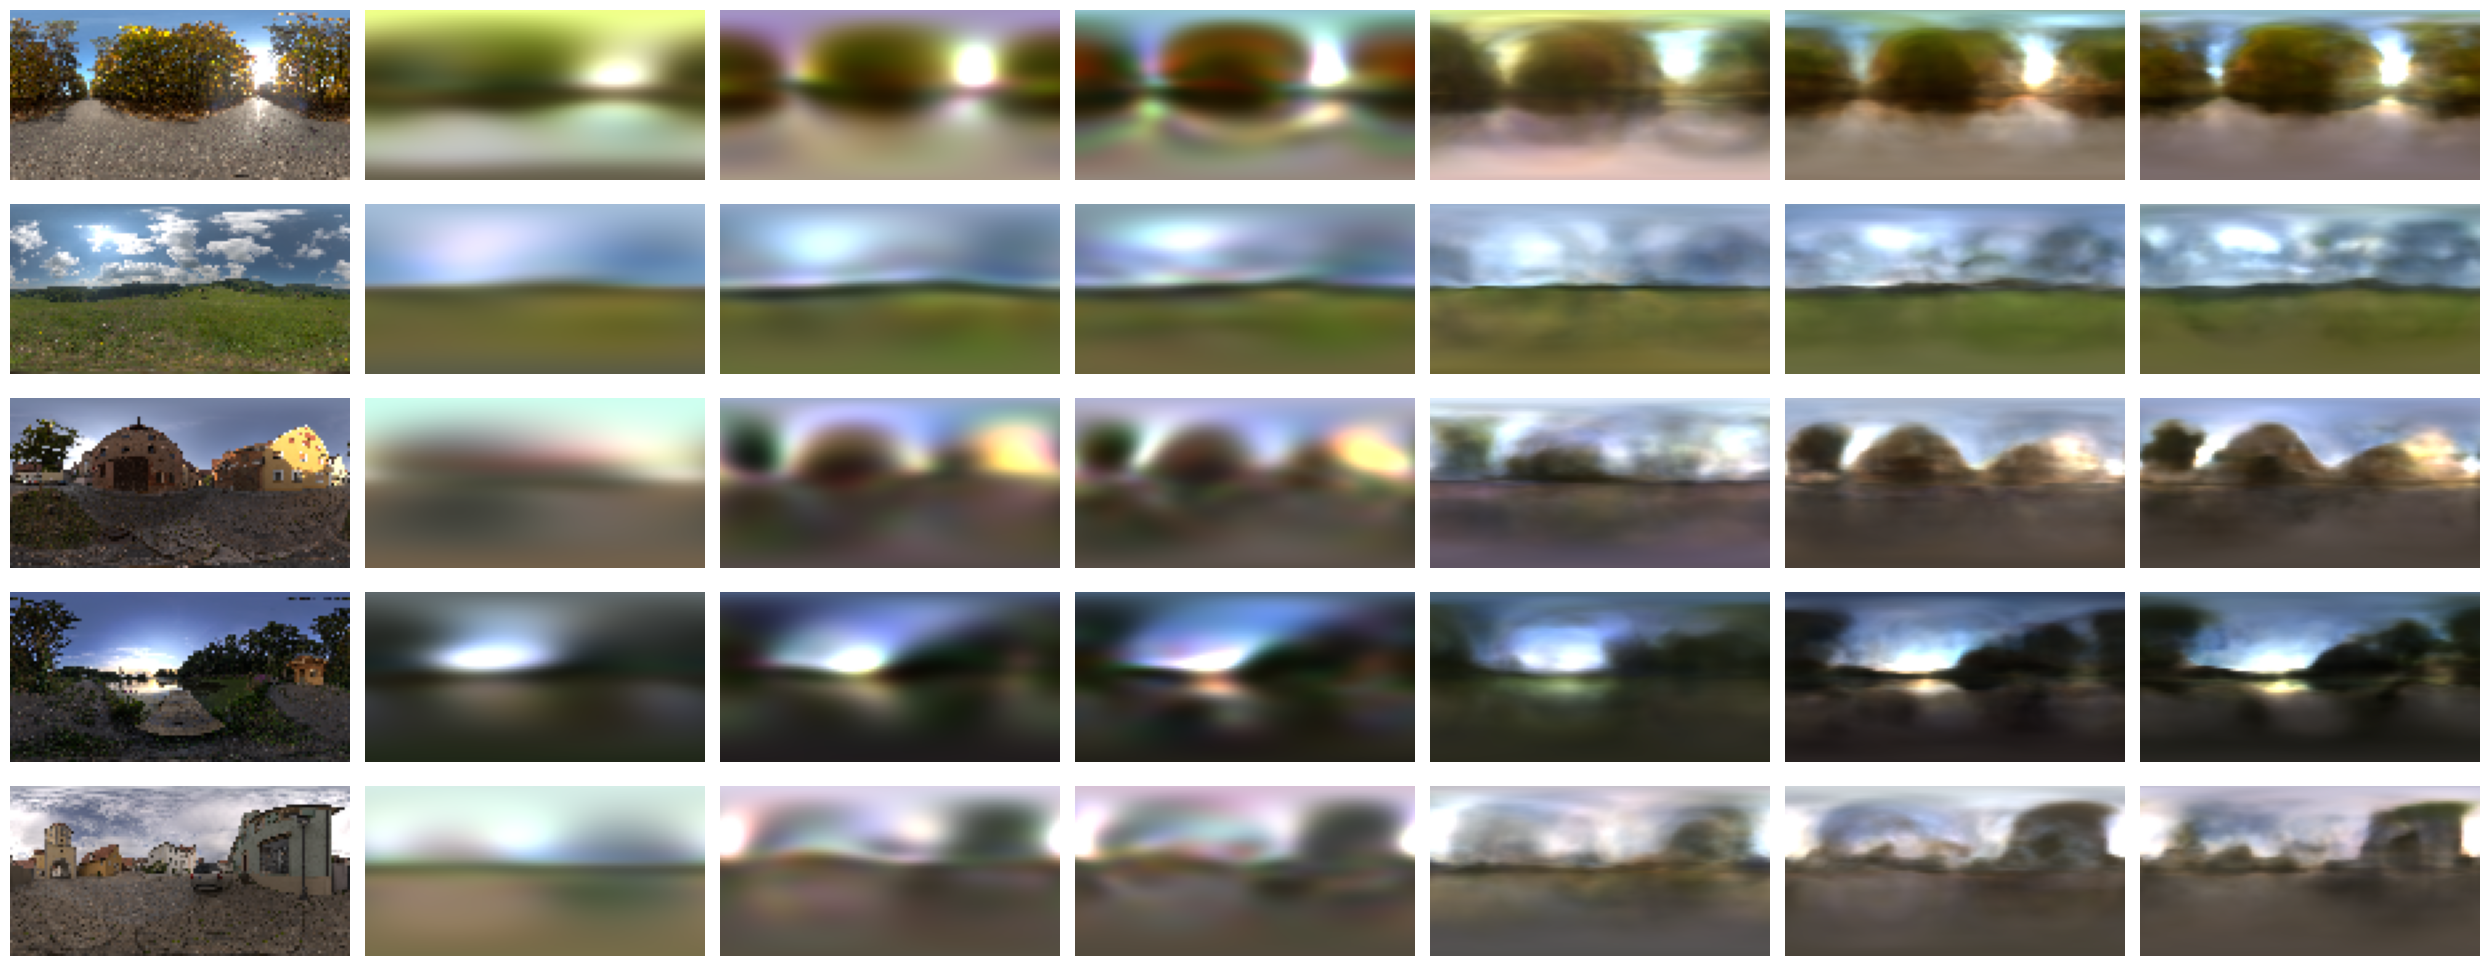

In [11]:
def old_vs_new_figure(old_output_images, new_output_images, keys, image_indices, filename=None):
    n_rows = len(image_indices)
    n_cols = len(keys) * 2 + 1  # Twice the number of keys (old and new models) + 1 for ground truth
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 10))
    
    for i, idx in enumerate(image_indices):
        # Plot ground truth image (assuming it's consistent between old and new output images)
        gt_img = old_output_images[keys[0]][idx]['gt_img']
        axes[i, 0].imshow(gt_img)
        axes[i, 0].axis('off')
        axes[i, 0].set_aspect(1)

        for j, key in enumerate(keys):
            # Plot pred_img for old models
            pred_img_old = old_output_images[key][idx]['pred_img']
            axes[i, j+1].imshow(pred_img_old)
            axes[i, j+1].axis('off')
            axes[i, j+1].set_aspect(1)
            
            # Plot pred_img for new models
            pred_img_new = new_output_images[key][idx]['pred_img']
            axes[i, j+1+len(keys)].imshow(pred_img_new)
            axes[i, j+1+len(keys)].axis('off')
            axes[i, j+1+len(keys)].set_aspect(1)
    
    plt.tight_layout()

    if filename:
        plt.savefig(f"{filename}.png")
        plt.savefig(f"{filename}.pdf")
    
    plt.show()

keys = ['latent_dim_9', 'latent_dim_49', 'latent_dim_100']
image_indices = [6, 7, 8, 9, 10]

old_vs_new_figure(old_output_images, new_output_images, keys, image_indices, filename='reni_neus/ns_reni/publication/figures/old_vs_new')

In [3]:
%%capture
model_paths = [
    '/workspace/outputs/reni/old_reni_models/latent_dim_9',
    '/workspace/outputs/reni/old_reni_models/latent_dim_36',
    '/workspace/outputs/reni/old_reni_models/latent_dim_49',
    '/workspace/outputs/reni/old_reni_models/latent_dim_100',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_9',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_36',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_49',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100',
    '/workspace/outputs/reni/spherical_harmonics/2nd_order',
    '/workspace/outputs/reni/spherical_harmonics/5th_order',
    '/workspace/outputs/reni/spherical_harmonics/6th_order',
    '/workspace/outputs/reni/spherical_harmonics/9th_order',
    '/workspace/outputs/reni/spherical_gaussians/num_param_30',
    '/workspace/outputs/reni/spherical_gaussians/num_param_108',
    '/workspace/outputs/reni/spherical_gaussians/num_param_150',
    '/workspace/outputs/reni/spherical_gaussians/num_param_300'
]

output_metrics = generate_numerical_results_from_models(model_paths)

In [11]:
def generate_latex_table(dim_to_keys, output_metrics):
    # Function to format the metric value, bold for best
    def format_metric(metric_value, best, is_better_high):
        # Determine if best is higher or lower for this metric
        if (is_better_high and metric_value == best) or (not is_better_high and metric_value == best):
            return f"\\textbf{{{metric_value:.2f}}}"
        else:
            return f"{metric_value:.2f}"

    # Start constructing the LaTeX table string
    table_latex = [
        "\\begin{table*}",
        "\\begin{center}",
        "\\caption{The mean PSNR, SSIM, and LPIPS scores when fitting to the test set for increasing latent dimensions. " +
        "Where an exact dimensionality comparison is not possible for SG, e.g. in the $D=27$ and $D=147$ cases, " +
        "we bias in favour of SG with a $D=30$ and $D=150$ respectively.}",
        "\\label{tab:comparison_PSNR_SSIM_LPIPS}",
        "\\begin{tabular}{| c | c | c | c | c |}",
        "\\hline",
        "$D$ & RENI & RENI++ & SH & SG \\\\",
        "& (PSNR/SSIM/LPIPS) & (PSNR/SSIM/LPIPS) & (PSNR/SSIM/LPIPS) & (PSNR/SSIM/LPIPS) \\\\",
        "\\hline"
    ]

    # Process each group of dimensions
    for dim, model_keys in dim_to_keys.items():
        # Initialize best metrics for the current dimension, with True for metrics where higher is better
        best_metrics = {
            'psnr_ldr': {'value': float('-inf'), 'is_better_high': True},
            'ssim_ldr': {'value': float('-inf'), 'is_better_high': True},
            'lpips_ldr': {'value': float('inf'), 'is_better_high': False}
        }
        
        # Update the best metrics for the current dimension
        for model_key in model_keys:
            if model_key in output_metrics:
                for metric, info in best_metrics.items():
                    current_value = output_metrics[model_key][metric]
                    if (info['is_better_high'] and current_value > info['value']) or \
                       (not info['is_better_high'] and current_value < info['value']):
                        best_metrics[metric]['value'] = current_value
        
        # Add the metrics for each model to the LaTeX table
        table_latex.append(f"{dim} & ")
        for idx, model_key in enumerate(model_keys):
            metrics = output_metrics[model_key]
            formatted_metrics = {
                metric: format_metric(metrics[metric], best_metrics[metric]['value'], best_metrics[metric]['is_better_high'])
                for metric in ['psnr_ldr', 'ssim_ldr', 'lpips_ldr']
            }
            if idx == len(model_keys) - 1:
                table_latex.append(
                    f"{formatted_metrics['psnr_ldr']}/{formatted_metrics['ssim_ldr']}/{formatted_metrics['lpips_ldr']} \\\\ \\hline"
                )
            else:
                table_latex.append(
                    f"{formatted_metrics['psnr_ldr']}/{formatted_metrics['ssim_ldr']}/{formatted_metrics['lpips_ldr']} & "
                )

    # Finish the LaTeX table string
    table_latex.extend([
        "\\end{tabular}",
        "\\end{center}",
        "\\end{table*}"
    ])

    # Return the full LaTeX table
    return "\n".join(table_latex)


dim_to_keys = {
    27: ['latent_dim_9_old', 'latent_dim_9', '2nd_order', 'num_param_30'],
    108: ['latent_dim_36_old', 'latent_dim_36', '5th_order', 'num_param_108'],
    147: ['latent_dim_49_old', 'latent_dim_49', '6th_order', 'num_param_150'],
    300: ['latent_dim_100_old', 'latent_dim_100', '9th_order', 'num_param_300']
}
# Generate and print the LaTeX table
latex_script = generate_latex_table(dim_to_keys, output_metrics)
print(latex_script)


\begin{table*}
\begin{center}
\caption{The mean PSNR, SSIM, and LPIPS scores when fitting to the test set for increasing latent dimensions. Where an exact dimensionality comparison is not possible for SG, e.g. in the $D=27$ and $D=147$ cases, we bias in favour of SG with a $D=30$ and $D=150$ respectively.}
\label{tab:comparison_PSNR_SSIM_LPIPS}
\begin{tabular}{| c | c | c | c | c |}
\hline
$D$ & RENI & RENI++ & SH & SG \\
& (PSNR/SSIM/LPIPS) & (PSNR/SSIM/LPIPS) & (PSNR/SSIM/LPIPS) & (PSNR/SSIM/LPIPS) \\
\hline
27 & 
17.02/\textbf{0.40}/0.75 & 
\textbf{18.02}/0.39/\textbf{0.62} & 
15.00/0.33/0.79 & 
17.67/0.35/0.80 \\ \hline
108 & 
19.58/0.45/0.75 & 
\textbf{20.81}/\textbf{0.49}/\textbf{0.56} & 
17.88/0.38/0.79 & 
19.27/0.41/0.70 \\ \hline
147 & 
19.97/0.46/0.74 & 
\textbf{21.13}/\textbf{0.51}/\textbf{0.55} & 
18.23/0.40/0.77 & 
19.81/0.43/0.67 \\ \hline
300 & 
20.47/0.48/0.73 & 
\textbf{22.09}/\textbf{0.55}/\textbf{0.52} & 
19.15/0.45/0.74 & 
20.24/0.46/0.61 \\ \hline
\end{tabular}
\en

In [3]:
# Teaser Figure
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import io
from matplotlib.cm import get_cmap

def plot_latent_vectors_and_crop(latent_code, num_vector_to_show=None):
    """
    Takes a latent code tensor, plots 3D vectors, and returns a cropped image of the plot.

    Args:
    latent_code (torch.Tensor): A tensor of shape (1, N, 3) containing N 3D vectors.

    Returns:
    np.ndarray: A cropped image array of the plot.
    """

    # Squeeze to remove the batch dimension if it's present
    if latent_code.dim() > 2:
        latent_code_np = latent_code.cpu().detach().numpy().squeeze()
    else:
        latent_code_np = latent_code.cpu().detach().numpy()

    # Optionally choose a subset of the vectors to show
    if num_vector_to_show is not None:
        latent_code_np = latent_code_np[:num_vector_to_show]

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Origin points (0,0,0) for each vector
    origin = np.zeros((len(latent_code_np), 3))  # N origin points

    # Choose a colormap
    cmap = get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(latent_code_np)))

    # Use quiver to plot vectors with the specified colors
    ax.quiver(origin[:, 0], origin[:, 1], origin[:, 2],
              latent_code_np[:, 0], latent_code_np[:, 1], latent_code_np[:, 2],
              color=colors, arrow_length_ratio=0.1)

    # Hide the axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # Set the range from -2 to 2 on all axes
    ax.set_xlim([-2.0, 2.0])
    ax.set_ylim([-2.0, 2.0])
    ax.set_zlim([-2.0, 2.0])
    
    # Save the figure to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='raw')
    buf.seek(0)

    # Read the buffer as a numpy array
    image_array = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    image_array = image_array.reshape(fig.canvas.get_width_height()[::-1] + (4,))

    # Crop the image
    width_start = 157
    width_end = 500
    height_start = 80
    height_end = 410
    cropped_image_array = image_array[height_start:height_end, width_start:width_end, :]

    # Close the figure to free memory
    plt.close(fig)

    return cropped_image_array

model_path = '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100'
pipeline, datamanager, model = load_model(Path(model_path))

num_random_samples = 5
image_idx = 0
images = {}
for i in range(num_random_samples + 3):
    # Your code to produce an image would go here.
    model.eval()
    _, ray_bundle, batch = datamanager.next_eval_image(image_idx)
    H, W = model.metadata["image_height"], model.metadata["image_width"]

    # High res image:
    H = 64
    W = H * 2
    cx = torch.tensor(W // 2, dtype=torch.float32).repeat(1)
    cy = torch.tensor(H // 2, dtype=torch.float32).repeat(1)
    fx = torch.tensor(H, dtype=torch.float32).repeat(1)
    fy = torch.tensor(H, dtype=torch.float32).repeat(1)

    c2w = torch.tensor([[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)

    cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

    ray_bundle = cameras.generate_rays(0).flatten().to(device)
    ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * image_idx

    # check if the model has attribute old_implementation
    if hasattr(model.field, 'old_implementation'):
        if model.field.old_implementation:
            get_rotation = rot_y
        else:
            get_rotation = rot_z

    rot_angle = 0.0
    if i == 1:
        rot_angle = 90.0
    rotation = get_rotation(torch.tensor(np.deg2rad(rot_angle)).float())
    rotation = rotation.to(device)
    
    ray_samples = model.create_ray_samples(ray_bundle.origins, ray_bundle.directions, ray_bundle.camera_indices)

    if i in [0, 1]:
        # latent_code = model.field.train_mu[image_idx].unsqueeze(0).to(device)
        # latent_code = latent_code.repeat(ray_bundle.shape[0], 1, 1)
        # outputs = model.field.forward(ray_samples=ray_samples, rotation=rotation, latent_codes=latent_code)
        outputs = model.field.forward(ray_samples=ray_samples, rotation=rotation)
        latent_code = model.field.train_mu[200]
        # rotate the latent code
        latent_code = torch.matmul(rotation, latent_code.unsqueeze(-1)).squeeze(-1)
        latent_code_image = plot_latent_vectors_and_crop(latent_code, 30)
    elif i == 2:
        latent_code = torch.zeros_like(model.field.train_mu[image_idx]).unsqueeze(0).to(device)
        latent_code = latent_code.repeat(ray_bundle.shape[0], 1, 1)
        outputs = model.field.forward(ray_samples=ray_samples, latent_codes=latent_code)
    else:
        # latent_code = torch.randn(1, model.field.latent_dim, 3).to(device)
        # choose two random idx from the training set and interpolate between them to create a new latent code
        idx_one = np.random.randint(0, len(datamanager.train_dataset))
        idx_two = np.random.randint(0, len(datamanager.train_dataset))
        latent_code_one = model.field.train_mu[i].unsqueeze(0).to(device)
        latent_code_two = model.field.train_mu[i+1].unsqueeze(0).to(device)
        latent_code = torch.lerp(latent_code_one, latent_code_two, 0.5)
        latent_code = latent_code.repeat(ray_bundle.shape[0], 1, 1)
        outputs = model.field.forward(ray_samples=ray_samples, latent_codes=latent_code)

    pred_img = model.field.unnormalise(outputs[RENIFieldHeadNames.RGB])
    # rehsape to H, W, C
    pred_img = pred_img.reshape(H, W, 3)
    pred_img = linear_to_sRGB(pred_img, use_quantile=True)

    if i in [0, 1]:
        images[i] = {'pred_img': pred_img.cpu().detach(),
                    'latent_code_image': latent_code_image}
    else:
        images[i] = {'pred_img': pred_img.cpu().detach()}

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

/home/user/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


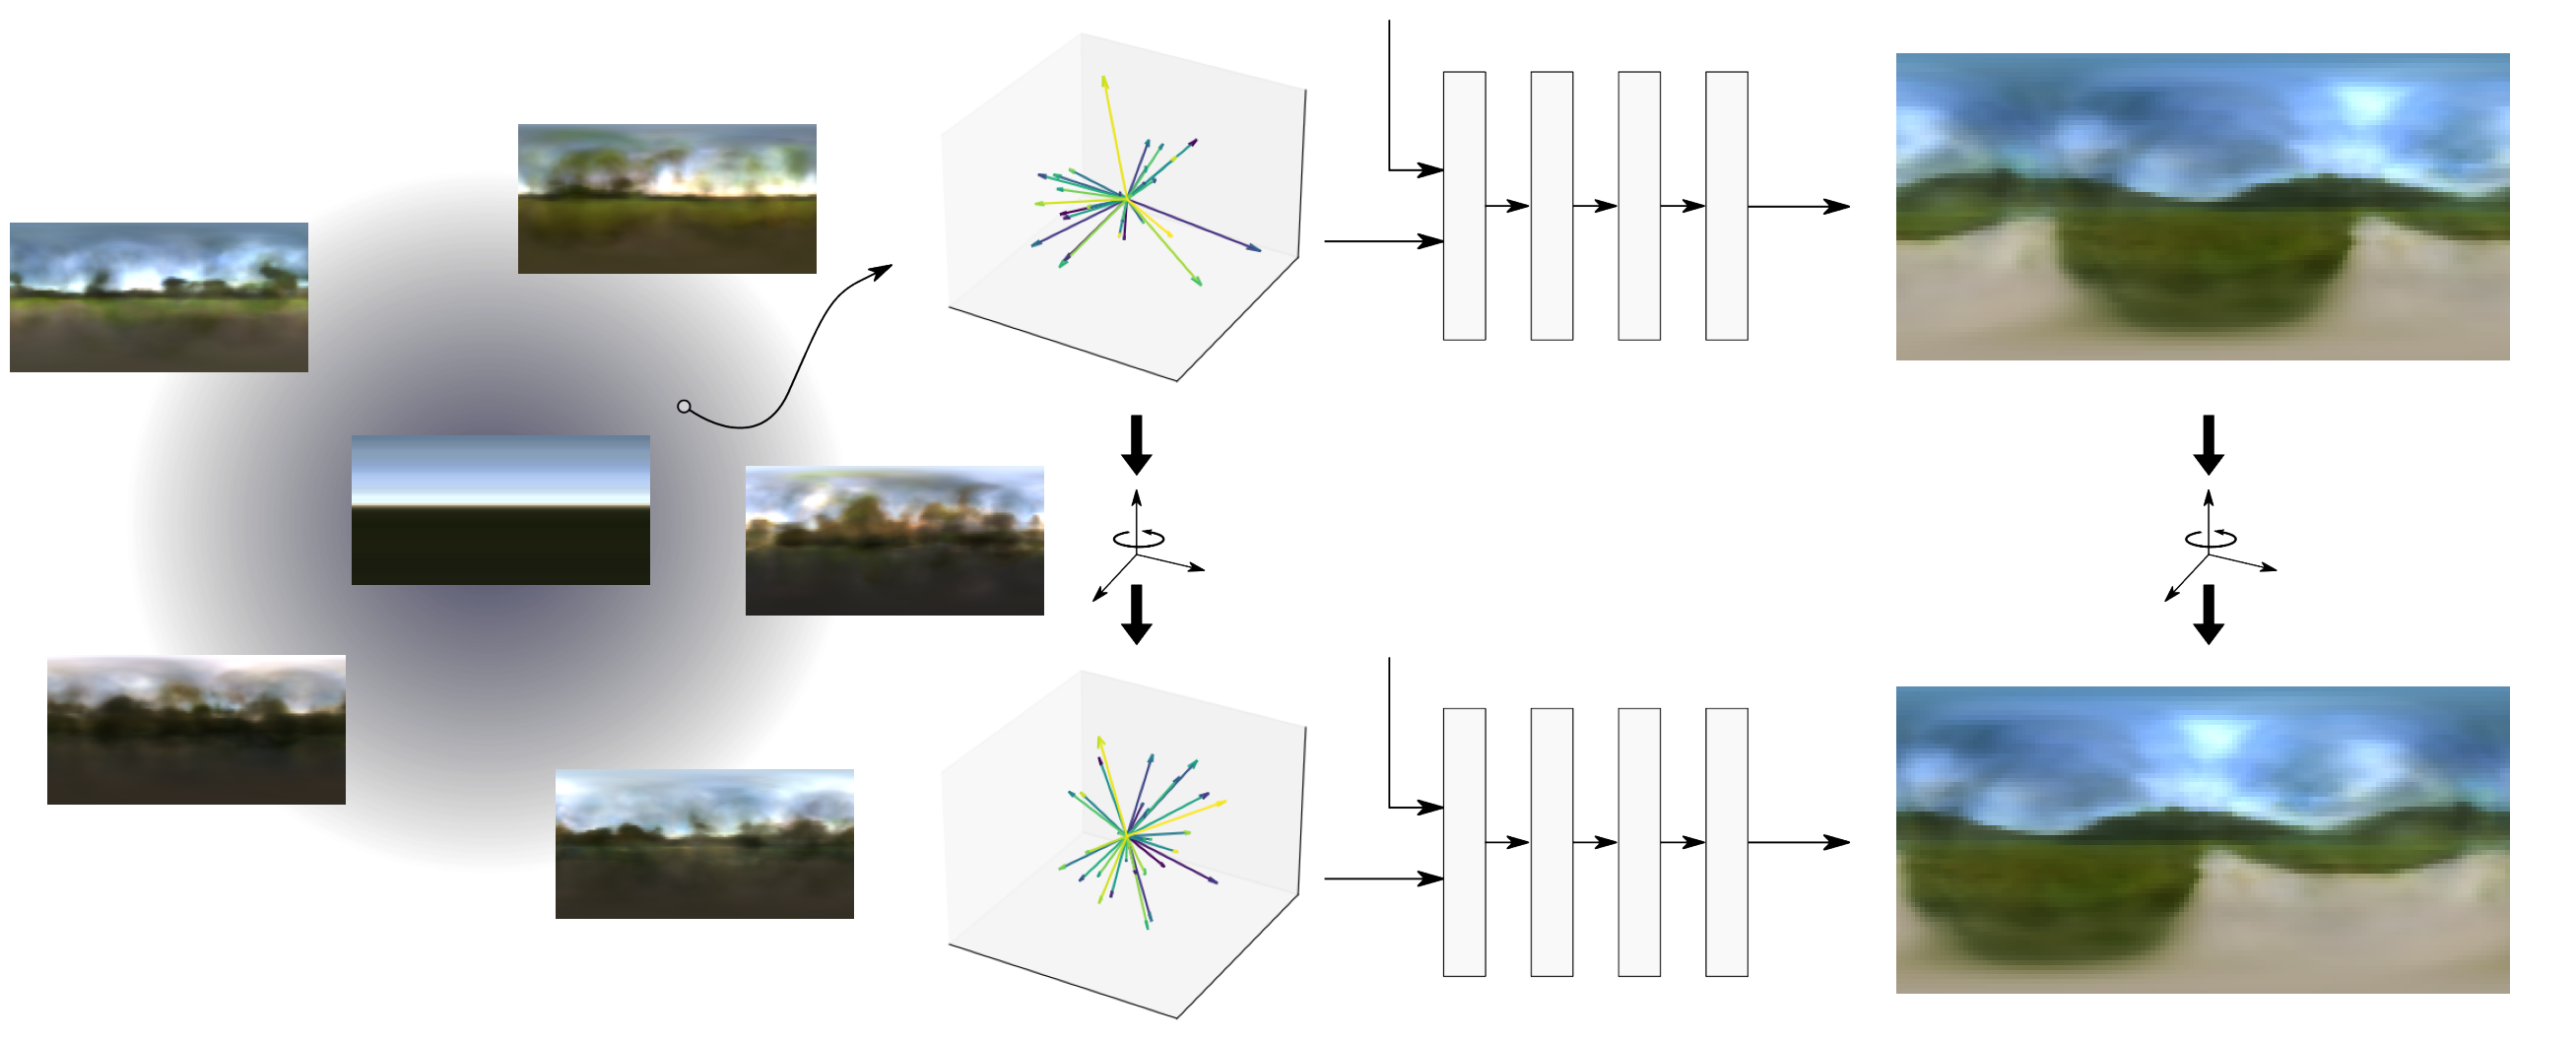

In [15]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

base_image_path = '/workspace/reni_neus/ns_reni/publication/figures/teaser_base.png'

base_image = plt.imread(base_image_path)

# Determine the resolution of the base image
base_image_height, base_image_width = base_image.shape[:2]

# Set the figure size in inches. One inch will correspond to `dpi` pixels.
dpi = 100  # This dpi value is just an example
fig_width = base_image_width / dpi
fig_height = base_image_height / dpi

fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
ax.imshow(base_image)
ax.set_axis_off()

# Display the base image
ax.imshow(base_image)
ax.set_axis_off()  # Hide the axes

# Dictionary for size and position data
image_properties = {
    'image1': {'x': 2875, 'y': 260, 'zoom': 3.5}, # GT 1
    'image2': {'x': 2875, 'y': 1095, 'zoom': 3.5}, # GT 2
    'image3': {'x': 630, 'y': 660, 'zoom': 1.7}, # MEAN

    'image4': {'x': 850, 'y': 250, 'zoom': 1.7}, # RANDOM 1
    'image5': {'x': 180, 'y': 380, 'zoom': 1.7}, # RANDOM 2
    'image6': {'x': 1150, 'y': 700, 'zoom': 1.7}, # RANDOM 3
    'image7': {'x': 230, 'y': 950, 'zoom': 1.7}, # RANDOM 4
    'image8': {'x': 900, 'y': 1100, 'zoom': 1.7}, # RANDOM 5
    
    'latent_code1': {'x': 1450, 'y': 260, 'zoom': 0.8},
    'latent_code2': {'x': 1450, 'y': 1100, 'zoom': 0.8},
}

# Modify your loop to use the image_properties for positioning and zoom
for i, img_tensor in enumerate(images):
    # Convert your PyTorch tensor to a numpy array
    img = images[img_tensor]['pred_img']

    # Extract the position and zoom from the image_properties dictionary
    prop_key = f'image{i+1}'
    img_props = image_properties.get(prop_key, {'x': 0, 'y': 0, 'zoom': 1.0})

    # Create an OffsetImage object for each overlay image
    imagebox = OffsetImage(img, zoom=img_props['zoom'])  # Set the zoom if necessary

    # Get the position where you want to place the image
    x, y = img_props['x'], img_props['y']

    # Create an AnnotationBbox to place the image at the given (x, y) position
    ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0)

    # Add the AnnotationBbox to the plot
    ax.add_artist(ab)

    if 'latent_code_image' in images[img_tensor]:
        # Convert your PyTorch tensor to a numpy array
        img = images[img_tensor]['latent_code_image']

        # Extract the position and zoom from the image_properties dictionary
        prop_key = f'latent_code{i+1}'
        img_props = image_properties.get(prop_key, {'x': 0, 'y': 0, 'zoom': 1.0})

        # Create an OffsetImage object for each overlay image
        imagebox = OffsetImage(img, zoom=img_props['zoom'])

        # Get the position where you want to place the image
        x, y = img_props['x'], img_props['y']

        # Create an AnnotationBbox to place the image at the given (x, y) position
        ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0)

        # Add the AnnotationBbox to the plot
        ax.add_artist(ab)

plt.savefig('/workspace/reni_neus/ns_reni/publication/figures/teaser.png', dpi=dpi, bbox_inches='tight', pad_inches=0)
plt.savefig('/workspace/reni_neus/ns_reni/publication/figures/teaser.pdf', dpi=dpi, bbox_inches='tight', pad_inches=0)

In [ ]:
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
from torch import nn, einsum, Tensor

import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import io
import itertools

from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.field_components.vn_layers import VNInvariant, VNLinear, VNReLU

import plotly.graph_objects as go

def get_3d_vector_plot(latent_code, vectors_to_show, seed=42, axis_size=2):
    """
    Plots a subset of 3D vectors from the latent code using Matplotlib and returns the plot as an image array.
    The quivers are colored with a repeatable set of colors.

    :param latent_code: torch.tensor -> [N, 3]
    :param vectors_to_show: int
    """

    random.seed(seed)

    # Define a list of colors
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan']
    color_cycle = itertools.cycle(colors)

    fixed_arrowhead_size = 0.2  # Adjust this value as needed

    # Ensure the latent code is a 2D tensor with shape [N, 3]
    if len(latent_code.shape) != 2 or latent_code.shape[1] != 3:
        raise ValueError("latent_code must be a 2D tensor with shape [N, 3]")

    # Ensure vectors_to_show is not greater than the number of vectors in latent_code
    vectors_to_show = min(vectors_to_show, latent_code.shape[0])

    # Select a random subset of vectors
    indices = random.sample(range(latent_code.shape[0]), vectors_to_show)
    vectors = latent_code[indices]

    # Initialize 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Add vectors to the plot
    for vector in vectors:
        vector = vector.cpu().numpy()  # Convert tensor to numpy array
        length = np.linalg.norm(vector)  # Calculate the length of the vector

        if length > 2:
            # Normalise the vector to length 2
            vector = (vector / length) * 2
            length = 2

        # Adjust arrow_length_ratio to maintain consistent arrowhead size
        arrow_length_ratio = fixed_arrowhead_size / length

        # Plot the vector with a color from the color cycle
        color = next(color_cycle)
        ax.quiver(0, 0, 0, vector[0], vector[1], vector[2], color=color, length=length, 
                  normalize=True, arrow_length_ratio=arrow_length_ratio)

    # Setting the ticks on each axis
    ax.set_xticks([-axis_size, 0, axis_size])
    ax.set_yticks([-axis_size, 0, axis_size])
    ax.set_zticks([-axis_size, 0, axis_size])

    # set axis labels as x, y and z
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # remove grid
    ax.grid(False)

    # Save the plot to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    img_array = np.array(img)
    buf.close()

    plt.close(fig)  # Close the figure to free up memory

    img_array = img_array[30:410, 20:395, :3]

    return img_array

model_path = '/workspace/neusky/ns_reni/models/reni_plus_plus_models/latent_dim_100'
pipeline, datamanager, model = load_model(Path(model_path))

# Your code to produce an image would go here.
model.field.config.view_train_latents = True
image_idx = 96
model.eval()
_, ray_bundle, batch = datamanager.next_eval_image(image_idx)
H, W = model.metadata["image_height"], model.metadata["image_width"]

# High res image:
H = 64
W = H * 2
cx = torch.tensor(W // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(H // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(H, dtype=torch.float32).repeat(1)
fy = torch.tensor(H, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(0).flatten().to(device)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * image_idx

batch['image'] = batch['image'].to(device)

ray_samples = model.create_ray_samples(ray_bundle.origins, ray_bundle.directions, ray_bundle.camera_indices)

Z = model.field.train_mu[image_idx]

Z = Z.unsqueeze(0).repeat(ray_samples.shape[0], 1, 1)

field_outputs = model.field.forward(ray_samples=ray_samples, latent_codes=Z)

pred_img = model.field.unnormalise(field_outputs[RENIFieldHeadNames.RGB])

pred_img = pred_img.view(H, W, 3)

normal_img = linear_to_sRGB(pred_img, use_quantile=True) # [H, W, 3]


negate = torch.eye(3, dtype=torch.float32).type_as(Z)
negate[0, 0] = -1

Z = model.field.train_mu[image_idx]

Z = torch.matmul(Z, negate)

Z = Z.unsqueeze(0).repeat(ray_samples.shape[0], 1, 1)

field_outputs = model.field.forward(ray_samples=ray_samples, latent_codes=Z)

pred_img = model.field.unnormalise(field_outputs[RENIFieldHeadNames.RGB])

pred_img = pred_img.view(H, W, 3)

x_negated_img = linear_to_sRGB(pred_img, use_quantile=True) # [H, W, 3]

negate = torch.eye(3, dtype=torch.float32).type_as(Z)
negate[1, 1] = -1

Z = model.field.train_mu[image_idx]

Z = torch.matmul(Z, negate)

Z = Z.unsqueeze(0).repeat(ray_samples.shape[0], 1, 1)

field_outputs = model.field.forward(ray_samples=ray_samples, latent_codes=Z)

pred_img = model.field.unnormalise(field_outputs[RENIFieldHeadNames.RGB])

pred_img = pred_img.view(H, W, 3)

y_negated_img = linear_to_sRGB(pred_img, use_quantile=True) # [H, W, 3]


negate = torch.eye(3, dtype=torch.float32).type_as(Z)
negate[2, 2] = -1

Z = model.field.train_mu[image_idx]

Z = torch.matmul(Z, negate)

Z = Z.unsqueeze(0).repeat(ray_samples.shape[0], 1, 1)

field_outputs = model.field.forward(ray_samples=ray_samples, latent_codes=Z)

pred_img = model.field.unnormalise(field_outputs[RENIFieldHeadNames.RGB])

pred_img = pred_img.view(H, W, 3)

z_negated_img = linear_to_sRGB(pred_img, use_quantile=True) # [H, W, 3]

model.field.config.view_train_latents = False

# plot normal_img center top and the three others in a row below
normal_img = normal_img.cpu().detach().numpy()
x_negated_img = x_negated_img.cpu().detach().numpy()
y_negated_img = y_negated_img.cpu().detach().numpy()
z_negated_img = z_negated_img.cpu().detach().numpy()

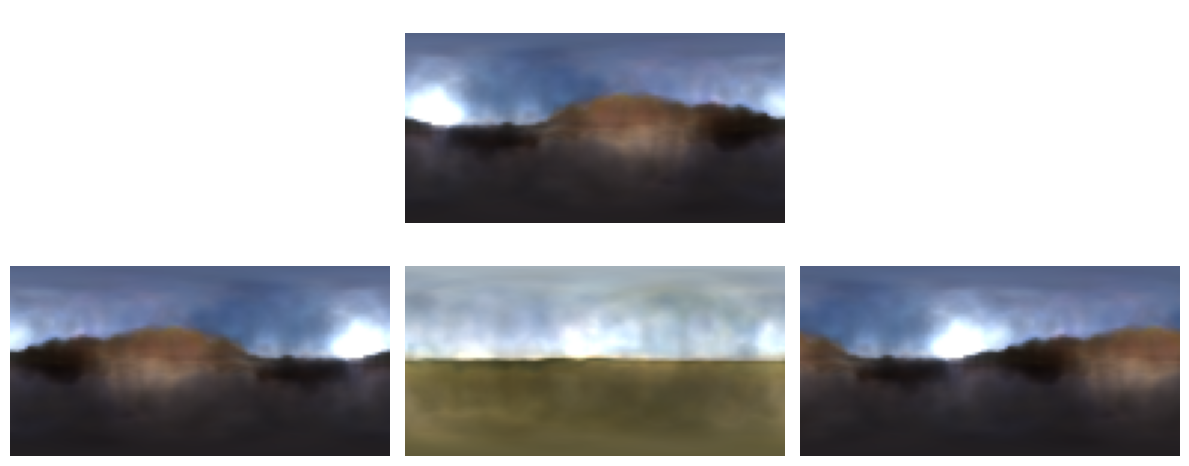

In [9]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 5))

# Hide the empty subplots
axs[0, 0].axis('off')
axs[0, 2].axis('off')

# Plot the images
axs[0, 1].imshow(normal_img)
axs[0, 1].axis('off')

axs[1, 0].imshow(x_negated_img)
axs[1, 0].axis('off')

axs[1, 1].imshow(z_negated_img)
axs[1, 1].axis('off')

axs[1, 2].imshow(y_negated_img)
axs[1, 2].axis('off')

# Display the plot
plt.tight_layout()

plt.savefig('/workspace/neusky/ns_reni/publication/figures/mirror.png')
plt.savefig('/workspace/neusky/ns_reni/publication/figures/mirror.pdf')